# Homework6

Words before the real parts beginning:
- `CMakeLists.txt` enables the google tests and the compiler Sanitizer. But I use this cmake **only in delevepment**, so not for evaluation.
- As said, Unit tests (google tests) can be found in: `Tester.cpp`, ` TestHashJoin.cpp`. Use cmake to build them and run them.
- I did some basic c++ code refactoring. 
- I only use the given makefile for evaluation.

If I mention *the paper*, then I mean implicit the **An Experimental Comparison of Thirteen Relational Equi-Joins in Main Memory, Stefan Schuh Et al.**.

# Hash Join

We are implementing and evaluating several parallel hash join strategies:
- `Baseline`: a native (single-pass partition radix join)
- `Parallel Hash Join`
- `NUMA Hash Join`

<br>

- The names do not say much. These two hash join strategies differ not so much: they are use multi-threading and synchronization at the necessary critical sections.
- The real differences is mentioned at the paper. I try my best to following the idea in the paper. I don't mention the differences here.
- Another thing I found the paper and the homework conflicting is, the paper just use single-pass partition.
> Single-pass Partitioning. The original PRO used two-pass radixpartitioning. We ran micro-benchmarks on PRO comparing singlepass and two-pass partitioning and also determined the optimal
number of partitions to use for partitioning. Figure 2 shows that a single-pass partitioning using 14 bits leads to the highest throughput. We will use this setting in the following for all variants of PRO.

Since the figures from paper are also focusing on single-pass partition. I decided just to code the single-pass partition. More detail discussed in the TODO/Question part.


---

## Dataset: Relation R join with Relation S

This dataset is similar with the paper's dataset-size:

```c++
  constexpr uint64_t domain = 16;
  constexpr uint64_t size_r = 1 << 23;  // 8Mi  * 16 Byte = 128 MiB
  constexpr uint64_t size_s = 1 << 26;  // 64Mi * 16 Byte = 1024 MiB | 1GiB
  // Change the partitioning bits to vary the granularity
  constexpr uint8_t partitioningBits = 14;
  std::srand(std::time(nullptr));

  relation r(size_r);
  relation s(size_s);

  // Fill r
  for (size_t i = 0; i < size_r; i++) {
    tuple_t t;
    t.key = rand() % (1 << domain);
    r[i] = t;
  }

  // Fill s
  for (size_t i = 0; i < size_s; i++) {
    tuple_t t;
    t.key = rand() % (1 << domain);
    s[i] = t;
  }
```

`partitioningBits` is still a stuff, that has to be examined to check, which partition pattern can has a peak performance. But it is still depending on the dataset size / value distribution / hash function ...

## Micro-benchmark Evaluation

Have to point out: *Cycles*, *Instructions*, *L1-misses*, *LLC-misses*, *Branch-misses*, *Task-clock* are nominalized with **number of element in Relation R**, so (1 << 23), namely 8388608.
So they are metrics **per tuple**, like cycle per tuple, cache miss per tuple ...

### Baseline

| Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|
|   293.79| 102917.11|    132372.79|   2112.59|     417.44|          9.76|   35021.99| 1.29| 1.00| 2.94 |

<br>
<br>

### Parallel Hash Join

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|    81.28| 27507.63|      8917.47|    630.51|      93.48|         22.47|    9690.68| 0.32| 1.00| 2.84  |
|       2|    48.47| 25810.89|      9724.24|    668.25|      93.87|         22.53|    9136.33| 0.38| 1.58| 2.83 |
|       4|    33.02| 26628.07|     11343.56|    744.09|      93.94|         22.69|    9590.51| 0.43| 2.44| 2.78 |
|       8|    25.40| 28319.64|     14648.79|    897.11|      95.30|         23.40|   10572.88| 0.52| 3.49| 2.68 |
|      16|    21.93| 34760.52|     21634.05|   1205.48|     101.57|         24.78|   13150.64| 0.62| 5.03| 2.64 |
|      32|    22.43| 60814.85|     36314.03|   1568.51|     124.53|         27.68|   23237.23| 0.60| 8.69| 2.62 |
|      64|    30.31| 110956.66|     68165.03|   2721.87|     136.21|         36.64|   42537.82| 0.61| 11.77| 2.61 | 

- Generally the instruction increase as the number of threads is increasing. 
- We can see that simply add more threads does not scale this program smoothly. Quickly to find the minimal runtime is at case with 16 threads.
- But the cache-miss-ratio start to grow, when we are using more than 16 threads. The reason, that is the purpose of this assignment, is the NUMA. The detailed reason is that the experiment environment CPU has 2 NUMA node, which has 10 cores and 20 hardware threads. So if we just ignore the NUMA property and use about 16 threads, it is possible that threads are running on (supported by) cores of different NUMA nodes. If we use more than 20 thread, then this behavior becomes a fact.  https://en.wikipedia.org/wiki/Pigeonhole_principle  :D
- As above mentioned, if threads are running on different NUMA nodes, they have to access (read, write) the relations and partitions. The remote access suffer from higher latency because of the NUMA Node Interconnection Networking. Thus a cache miss costs us **more time** than on a normal UMA system.

<br>
<br>

### NUMA Hash Join

The code I added for NUMA-Awareness into the function assigned and executed by each thread:

```c++
/// runs the current task and its children on a specific node.
/// E5-2660 v2 hash 2 Sockets (2 NUMA node)
/// Thread [0, 19] on Node 0 | Thread [20, 39] on Node 1 | Thread [40, 59] on Node 0 | Thread [60, 59] on Node 1 | ......
// TODO(jigao): I am not sure. Hope this works!
const int node_id = (num_threads / 20) & 1;
if (numa_run_on_node(node_id) != 0) {
  printf("could not assign current thread to node %d!\n", 1);
}
numa_set_preferred(node_id);
```

<br>
<br>

| Threads | Runtime | Cycles | Instructions  |  L1-misses | LLC-misses  | Branch-misses   | Task-clock  | IPC  |  CPU |  GHz |
|---|---|---|---|---|---|---|---|---|---|---|
|       1|    68.21| 24022.25|      8315.78|    591.96|      93.56|         22.28|    8132.52| 0.35| 1.00| 2.95 | 
|       2|    36.63| 24228.93|      8318.03|    585.38|      93.85|         22.44|    8610.18| 0.34| 1.97| 2.81 | 
|       4|    19.81| 24009.03|      8323.85|    581.60|      94.67|         22.60|    9053.86| 0.35| 3.83| 2.65 | 
|       8|    11.10| 25191.77|      8301.92|    581.56|     101.38|         22.94|    9675.69| 0.33| 7.31| 2.60 | 
|      16|     7.88| 33352.66|      8152.18|    602.35|     123.14|         23.70|   12817.36| 0.24| 13.65| 2.60 | 
|      32|     9.49| 47420.74|      8255.09|    613.80|     137.66|         24.63|   18222.45| 0.17| 16.11| 2.60 | 
|      64|     9.55| 46780.23|      8246.91|    629.26|     152.33|         26.17|   17981.75| 0.18| 15.79| 2.60 | 


- I only did the above mentioned code, which is explicitly NUMA-aware. But as mentioned, in the paper, there is some difference between the implementations of these two hash joins. We can observe this trend from the single-threaded version. The single-threaded NUMA Hash Join is about 20% faster than the other at the runtime. But the hardware metrics are not so different between these both cases. 
- Then we keep on compare the multi-threading cases. We can still re-find that the case with 16 threads has the best runtime. The reason is the same discussed above. There to pointer out, we just code sensible code to be NUMA-aware, but we can NEVER eliminate the hardware latency from remote access. We can do is just reduce the number of remote accesses. So the best performance in my cases is always at the 16 threads' case, where a single NUMA-node locally solve this problem. 
- I think the last statement is not general. If we have a larger problem to solve, where adding more threads can bring performance. Then the cost of remote-access can be **paid off** by the computation ability of a remote hardware thread. I think even in this problem, it is still possible to achieve this dream. But advanced coding and more time are acquired. :D
- It is quite significant, even we just roughly go through these hardware metrics without any focused attention. The best runtime are much much better than the trivial parallel hash join. The cache misses grows, as the reason we discussed, but they vary in a very satisfying range, while the cache-miss-ratio parallel hash join grows wildly.

Some important wording from the paper and posts (reflected in my implementation):
- > In contrast to PRO, at this point we **neither have physically contiguous probe nor build partitions available**.
- > However, in contrast to PRO, we do not require the inputs to each join to be physically contiguous in main memory. Therefore, CPRL **trades small random writes to remote memory for large sequential reads from remote memory**.
- NUMA First Touch Policy: https://stackoverflow.com/questions/49105427/c-numa-optimization
- Barrier: https://stackoverflow.com/questions/24465533/implementing-boostbarrier-in-c11, https://stackoverflow.com/questions/38999911/what-is-the-best-way-to-realize-a-synchronization-barrier-between-threads

<br>
<br>
<br>
<br>

- Question: why is the instructions per tuple a constant?
- A point: I did see in homework:
> Equally divide the input tuples amongst tasks (τ ). Set the number of tasks (#τ ) to 4 × #threads. In practice, this is a good heuristic.

I did hard-coded thread-pool for task scheduling. But I found this did not give any speed up. So I just simply not use this **4 times**. This is because the dataset after partition is already even. It can also depends on the synchronization way I choose, how to set my Thread-Barrier. I think I distribute the work already evenly, more threading can brings more overhead.


In [1]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 9) # (w, h)

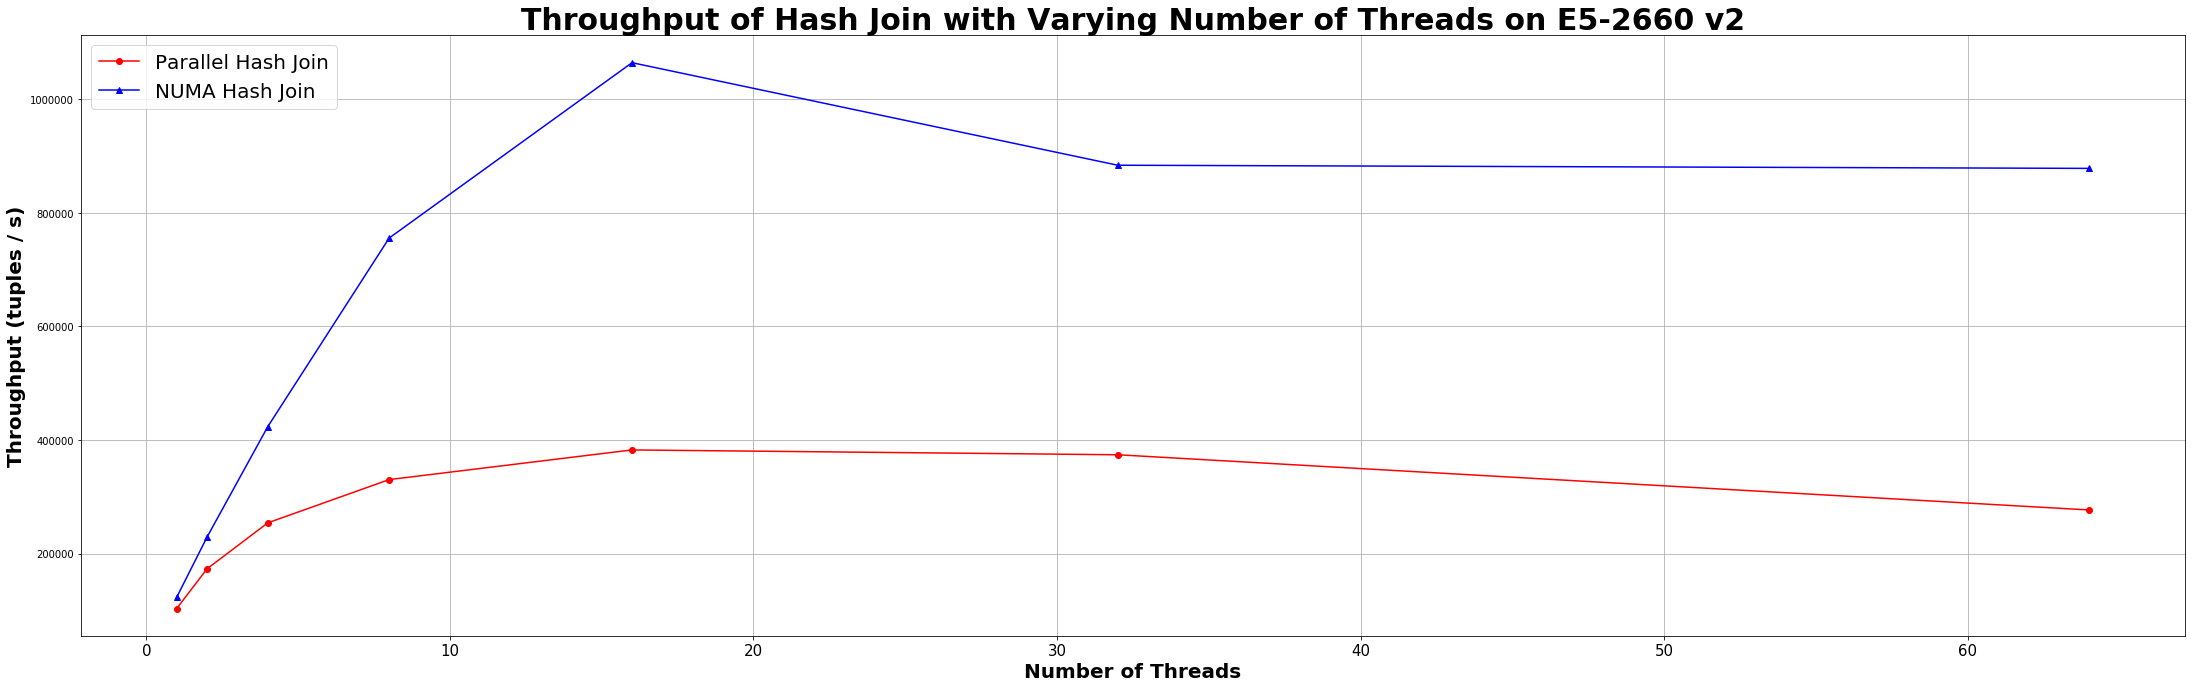

<Figure size 28800x14400 with 0 Axes>

In [10]:
df_o   = pd.read_csv("p_hj.csv")
thread   = df_o['thread']
time_o   = 8388608.0 / df_o['time']

df_olc   = pd.read_csv("numa_hj.csv")
time_olc   = 8388608.0 / df_olc['time']

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tight_layout()

plt.plot(thread, time_o, 'ro-', thread, time_olc, 'b^-')

plt.title('Throughput of Hash Join with Varying Number of Threads on E5-2660 v2', fontsize=30, fontweight='bold')
plt.xlabel('Number of Threads', fontsize=20, fontweight='bold')
plt.ylabel('Throughput (tuples / s)', fontsize=20, fontweight='bold')
plt.legend(['Parallel Hash Join', 'NUMA Hash Join'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

- So the figure above we can compare then throughput by adding more threads. As said, I think it is possible to have a program in our context to full utilize two NUMA nodes -- all 40 threads. 
- But my code is not capable to scale so well. But it can guarantee at least, if less than 20 threads, use all NUMA node local threads and memory. So we see a linear speedup before, the number of thread is 20.
- As for the trivial parallel hash join, which is apparently not NUMA-aware or NUMA-friendly approach on our NUMA CPU.

# Conclustion

It is the first time that I really touch NUMA-coding, not a minimal toy example. Before that I thought NUMA is a beast, not only the computational ability, as also the coding complexity. 

But this experience turns out that my expectation is wrong, and I should not be scared by the NUMA. 

(But still there are very limited example and documentation about NUMA.)

The performance improvement is significant and easy to find the pattern to locate the reason. The paper provides also a valid foundation. 

# Appendix

## Experiment Environment

All the experiments are performed on a Intel(R) Xeon(R) CPU E5-2660 v2 @ 2.20GHz:
```bash
$ lscpu
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              40
On-line CPU(s) list: 0-39
Thread(s) per core:  2
Core(s) per socket:  10
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               62
Model name:          Intel(R) Xeon(R) CPU E5-2660 v2 @ 2.20GHz
Stepping:            4
CPU MHz:             2764.193
CPU max MHz:         3000.0000
CPU min MHz:         1200.0000
BogoMIPS:            4399.72
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            25600K
NUMA node0 CPU(s):   0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38
NUMA node1 CPU(s):   1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm cpuid_fault pti ssbd ibrs ibpb stibp tpr_shadow vnmi flexpriority ept vpid fsgsbase smep erms xsaveopt dtherm ida arat pln pts md_clear flush_l1d

```


# TODO & Quesstion: 
(This time I would focus on this part :D )

1. I am very curious about the **Figure 6 from the paper**. Yes this figure is also shown in our lecture slide. 
  - I am glad if we can see such thing in our tutorial session and **talk about how to have such figure**. I see it is from Intel VTune GUI.  Maybe we can have this last homework to show how to general use the Intel VTune, if it is not time consuming. 
  - I think such figure is the ultimate way to prove, that the **NUMA-Awareness** is essential for programming on NUMA-CPUs. My micro-benchmark is just to show the Cache-Hit or the Cache-Miss ratio, which is not so impressive from the hardware property of NUMA. 
  - From this Figure 6, it is glass clear, how intensive the memory bus is utilized and how long is the memory bus is utilized. Another point from thus figure is that, we can almost make a conclusion, that the paper's approach is optimal, since the memory bus is limited by its bandwidth to the largest usage-time. So the bandwidth and usage-time are maximal, so the performance is also maximal (means still memory bound :D).
  - So it is the first time that I really care about the peak-bandwidth-usage-time of memory bus. And it is also the first time that I see such figure in a paper. I am very impressed. Hope to learn it somehow. 
  
2. Why is the instructions per tuple of NUMA Hash Join a constant?

3. I found that in Part 1 - First Level Partitioning, there is no necessary barrier between step(2) and step(3), if we did enough synchronization between step(1) and step(2). I didn't use one barrier between them. 

4. I think the Task-Level Parallelism (TLP) is a dynamical programming problem. Especially when the task has different size or different complicity, thus each thread needs very different runtime for each task individually. Somehow a intelligent and dynamic dispatch has to pay attention to the task queue, dispatch the individual task to thread, and send notification to threads or receive notification from threads.

In this work we just use mock-up random dataset, which can be easily **static** scheduled by **us**, which just means divide the task with same workload. Then the TLP is not a big issue. But general TLP is just a un-relevant topic with our hash join and NUMA. We can speed a whole semester (even longer) on that topic:
- IN2147: https://campus.tum.de/tumonline/WBMODHB.wbShowMHBReadOnly?pKnotenNr=457062
- IN2365: https://www.in.tum.de/caps/lehre/ws18/vorlesungen/parallel-programming-systems/

It becomes very sophisticated, maybe the same level sophisticated as the DBMSs. The result can be a runtime system overall to efficiently control the program and does scheduling. The possible result are: OpenMP and Intel TBB, which are the super important topic in the listed lectures. I see them beneficial, since they can save the programming effort and the runtime overhead. There is a well-implemented thread pool in them, which is aiming to lower the cost to spawn threads, reuse threads. They are more efficient and can do the work, which the C++ standard `std::thread` primitives can't do. I didn't use them in this homework, but I think if I use one of them, the coding time can be reduced and the runtime performance can be a bit better.

5. I repeat that why I choose over single-pass partition over multi-pass partition:
    - Single pass partition is more simple to code. The second partition has a annoying tailing part, which is a nightmare to handle then individually. Also possible synchronization necessary. I don't feel it is valuable to do so, we are not focusing on a real-work dataset.
    - Single pass partition is detailed described in the paper. Re-implement and re-perform the experiments is also valuable and not time-consuming.
    - Actually I did hard-coded the parallel hash join with multi-pass partition with extra coding effort. Even speeding a while to code it thread-safe and pass my own written test. Then I started to implement the NUMA code and found this point is inconsistent with the paper. I did considered this point for a long time. It can be an issue from my perspective, at least hard to implement, at worst cases can brings unnecessary overhead or hard to get paid off:

![Parallel Hash Join](p1.png)

![NUMA Hash Join](p2.png)

(If the picture is not shown, just refer to `p1.png` and `p2.png` in this repo. The markdown sometime works but sometime not.)

(Pleas ignore the noisy at the picture boundary.) 

Just simple wording additionally, we see already plenty of frames within local partitions in the NUMA Hash Join case. If we just divide each little small frame into out Fanout, then we get our result of second level partition. I think it is too much partitioned.